# Búsquea Learning Rate para SAC
En este cuaderno se va a realizar la experimentación necesaria para obtener el valor óptimo del hiperparámetro *learning rate* para el algoritmo SAC(Soft Actor Critic).

Esta búsqueda del valor óptimo se va a hacer a través de una técnica conocida como *learning rate schedule*, la cual va variando el valor de la tasa de aprendizaje a lo largo del entrenamiento para observar las recompensas que se van obteniendo para cada valor.

## Instalar las librerías del entorno
En primer lugar se hace una descarga e instalación de las librerías que se van a usar para modelar el entorno en el que se va a entrenar al agente.

La primera de las librerías corresponde a un repositorio propio que se ha originado a través de un fork a otro repostorio en el que se había creado un *framework* orientado principalmente al desarrollo de entornos similares a los que se presentan en la Robocup, el cual es uno de los campeonato de fútbol robótico más conocidos a nivel mundial. Lo bueno de dicho repositorio es que los entornos que ya tiene implementados son de robots móviles y en especial los entornos VSS están formados por robots con unas carácterísticas hardware ciertamente similares a los turtlebots.

La segunda librería es *gymnasium* y es un estandar dentro de la programación de entornos orientados al aprendizaje por refuerzo.

In [1]:
!pip install gymnasium
!pip install git+https://github.com/pablocarpon/rSoccer.git

  Cloning https://github.com/pablocarpon/rSoccer.git to /tmp/pip-req-build-8gd3n018
  Running command git clone --filter=blob:none --quiet https://github.com/pablocarpon/rSoccer.git /tmp/pip-req-build-8gd3n018
  Resolved https://github.com/pablocarpon/rSoccer.git to commit bf8b88bb228835b67aba3f3b967624a12aba226a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Instalar las librerías del agente
Tras instalar las librerías de Python que me van a ayudar a progamar el entorno, hago lo mismo con las que contienen algoritmos para regir el comportamiento del agente y optimizar su entrenamiento.

En este caso estoy usando *stable_baselines3* que recoge varios algoritmos de aprendizaje por refuerzo escritos sobre la librería *pytorch*.

La tercera línea de la celda inferior sirve para instalar también librerías como *tqdm* y *rich*, las cuales sirven para poder usar un *callback* que tiene *stable-baselines3* implementado con el fin de monitorizar el tiempo transcurrido durante el entrenamiento y el tiempo estimado que queda para finalizar el entrenamiento. Dicho *callback* recibe el nombre de *ProgressBarCallback*.

In [2]:
!pip install stable_baselines3

## Importar todas las librerías necesarias
Tras la instalción se importan al cuaderno todos los módulos que voy a necesitar para el entrenamiento del modelo.

In [3]:
import rsoccer_gym
import gymnasium as gym

import stable_baselines3
from stable_baselines3 import SAC

# Entrenamiento del modelo
En esta sección se va a proceder a entrenar el modelo con un learning rate asociado a una función que lo irá calculando en cada momento.

Para esta experimentación se van a definir dos funciones de búsqueda del learning rate óptimo. Ambas funciones aceptan como parámetro el valor inicial de la tasa de aprendizaje, pero una de ellas irá aumentando el valor hasta 1 conforme pasa el tiempo y la otra lo irá reduciendo hasta 0.

Con esto se pretende ver si los valores óptimos son capaces de converger en un punto o área.

In [4]:
# Number of times each experiment has to repeat to have a more reliable
# hyperparameter tuning
EX_LOOP = 3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## EXPERIMENT 1

def linear_schedule_down(initial_value: float):
    """
    Linear learning rate schedule. The learning rate value will decrease

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

for i in range(EX_LOOP):
  if i > 0:
    del env
    del model_down
  # Initial learning rate of 0.001
  env = gym.make('VSS1vs1-v0')
  csv_name = f"log{i}_SAC_down"
  env = stable_baselines3.common.monitor.Monitor(env,csv_name)
  env.reset()
  model_down = SAC("MlpPolicy", env, learning_rate=linear_schedule_down(0.01), verbose=1)
  model_down.learn(total_timesteps=500_000)

Se han truncado las últimas 5000 líneas del flujo de salida.
| time/              |          |
|    episodes        | 116      |
|    fps             | 85       |
|    time_elapsed    | 1564     |
|    total_timesteps | 134365   |
| train/             |          |
|    actor_loss      | -95.8    |
|    critic_loss     | 1.13e+03 |
|    ent_coef        | 0.124    |
|    ent_coef_loss   | -2.32    |
|    learning_rate   | 0.00731  |
|    n_updates       | 134264   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 120      |
|    fps             | 85       |
|    time_elapsed    | 1620     |
|    total_timesteps | 139165   |
| train/             |          |
|    actor_loss      | -116     |
|    critic_loss     | 971      |
|    ent_coef        | 0.0931   |
|    ent_coef_loss   | -0.127   |
|    learning_rate   

In [5]:
## EXPERIMENT 2

def linear_schedule_up(final_value: float):
    """
    Linear learning rate schedule.The learning rate value will increase

    :param final_value: Final learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return (1-progress_remaining) * final_value

    return func

for i in range(EX_LOOP):
  if i > 0:
    del env
    del model_up
  # Initial learning rate of 0.001
  env = gym.make('VSS1vs1-v0')
  csv_name = f"log{i}_SAC_up"
  env = stable_baselines3.common.monitor.Monitor(env,csv_name)
  env.reset()
  model_up = SAC("MlpPolicy", env, learning_rate=linear_schedule_up(0.01), verbose=1)
  model_up.learn(total_timesteps=500_000)

Environment initialized
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.2e+03  |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 87       |
|    time_elapsed    | 54       |
|    total_timesteps | 4800     |
| train/             |          |
|    actor_loss      | -19.8    |
|    critic_loss     | 0.0351   |
|    ent_coef        | 0.794    |
|    ent_coef_loss   | -0.774   |
|    learning_rate   | 9.6e-05  |
|    n_updates       | 4699     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09e+03 |
|    ep_rew_mean     | -9.5     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 87       |
|    time_elapsed    | 99       |
|    total_timesteps | 8720     |
| train/             |          |
|    

# Mostrar gráficas archivos CSV
Por último, se crean las gráficas que representan la evolución media de las recompensas a lo largo de los valores de *learning rate* a partir de los archivos CSV que se han guardado gracias al *wrapper* Monitor que se ha instanciado.

Habra dos gráficas, una representará la evolución de las recompensas para el caso en el que la tasa de aprendizaje es ascendente y otra para cuando el valor de dicha tasa va descendiendo. Esta distinción es debida a que en los primeros momentos en los que el algoritmo se va ejecutando este realmente no mejora su comportamiento de forma muy notable porque todavía está aprendiendo. Esto hace que el verdadero impacto del valor de la tasa de aprendizaje se aprecie más en las iteraciones más cercanas al final del entrenamiento y por ello se ha querido que todos los valores de la tasa de aprendizaje que se querían testear se alojaran en la parte final del entrenamiento.

Además, se ha hecho una normalización de los valores de recompensa dividiendo todos los valores de cada uno de los archivos CSV entre el valor máximo de dicho archivo para mitigar el efecto que tiene el hecho de empezar con una recompensa muy alta o muy baja(puesto que es algo aleatorio).

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


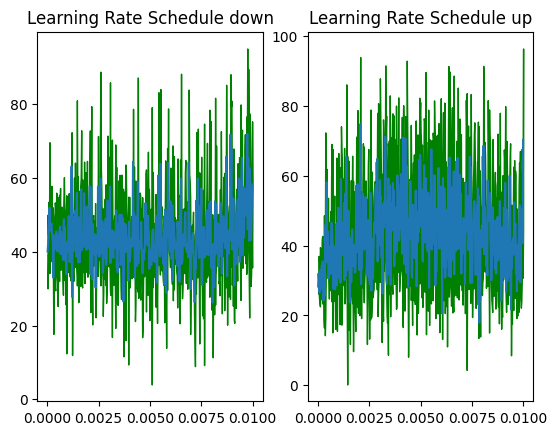

In [9]:
import os
from google.colab import drive
import csv
import numpy as np
import matplotlib.pyplot as plt


def norm_vector(vec):
  positive_vec = vec + abs(np.min(vec))
  norm_vec = positive_vec * 100 / np.max(positive_vec)
  return norm_vec


def calculate_media_std(vec1, vec2, vec3):
  final_array = []
  vec1 = norm_vector(vec1)
  vec2 = norm_vector(vec2)
  vec3 = norm_vector(vec3)

  for v1,v2,v3 in zip(vec1,vec2,vec3):
    final_array.append((v1+v2+v3)/3)
    final_array.append(np.std([v1,v2,v3]))

  return np.array(final_array).reshape(vec1.size, 2)


# Path to the folder containing csv files
FOLDER_PATH = "./drive/MyDrive/Colab Notebooks/TFG/Entrenamiento en rSoccer/Entorno simulado/Fase 1 Ajuste de hiperparámetros"

# Path to csv files
CSV_DOWN_0 = os.path.join(FOLDER_PATH, "log0_SAC_down.monitor.csv")
CSV_DOWN_1 = os.path.join(FOLDER_PATH, "log1_SAC_down.monitor.csv")
CSV_DOWN_2 = os.path.join(FOLDER_PATH, "log2_SAC_down.monitor.csv")
CSV_UP_0 = os.path.join(FOLDER_PATH, "log0_SAC_up.monitor.csv")
CSV_UP_1 = os.path.join(FOLDER_PATH, "log1_SAC_up.monitor.csv")
CSV_UP_2 = os.path.join(FOLDER_PATH, "log2_SAC_up.monitor.csv")

# Create a local directory to access my files stored in google drive
drive.mount("./drive")

# Create empty lists to fill them with rewards values of csv files and
# convert them to numpy arrays
reward_down_0 = []
reward_down_1 = []
reward_down_2 = []
with open(CSV_DOWN_0,"r") as csv0, open(CSV_DOWN_1,"r") as csv1, open(CSV_DOWN_2,"r") as csv2:
  csv0_read = csv.reader(csv0)
  csv1_read = csv.reader(csv1)
  csv2_read = csv.reader(csv2)
  next(csv0_read)
  next(csv1_read)
  next(csv2_read)
  for rows0, rows1, rows2 in zip(csv0_read, csv1_read, csv2_read):
    reward_down_0.append(float(rows0[0]))
    reward_down_1.append(float(rows1[0]))
    reward_down_2.append(float(rows2[0]))

reward_up_0 = []
reward_up_1 = []
reward_up_2 = []
with open(CSV_UP_0,"r") as csv0, open(CSV_UP_1,"r") as csv1, open(CSV_UP_2,"r") as csv2:
  csv0_read = csv.reader(csv0)
  csv1_read = csv.reader(csv1)
  csv2_read = csv.reader(csv2)
  next(csv0_read)
  next(csv1_read)
  next(csv2_read)
  for rows0, rows1, rows2 in zip(csv0_read, csv1_read, csv2_read):
    reward_up_0.append(float(rows0[0]))
    reward_up_1.append(float(rows1[0]))
    reward_up_2.append(float(rows2[0]))

reward_down_0 = np.array(reward_down_0)
reward_down_1 = np.array(reward_down_1)
reward_down_2 = np.array(reward_down_2)
reward_up_0 = np.array(reward_up_0)
reward_up_1 = np.array(reward_up_1)
reward_up_2 = np.array(reward_up_2)

# Create two arrays that represent the average values of 0, 1 and 2 arrays
norm_reward_down = calculate_media_std(reward_down_0, reward_down_1, reward_down_2)
norm_reward_up = calculate_media_std(reward_up_0, reward_up_1, reward_up_2)

# Create two arrays that represent the learning rate values
lr_down = np.linspace(0.01, 1e-5, num=428)
lr_up = np.linspace(1e-5, 0.01, num=459)

# Plot graphs
figure, axis = plt.subplots(1,2)

axis[0].set_title("Learning Rate Schedule down")
axis[0].plot(lr_down, norm_reward_down[:,0])
axis[0].fill_between(
    lr_down,
    norm_reward_down[:,0]-norm_reward_down[:,1],
    norm_reward_down[:,0]+norm_reward_down[:,1],
    color="green"
)

axis[1].set_title("Learning Rate Schedule up")
axis[1].plot(lr_up, norm_reward_up[:,0])
axis[1].fill_between(
    lr_up,
    norm_reward_up[:,0]-norm_reward_up[:,1],
    norm_reward_up[:,0]+norm_reward_up[:,1],
    color="green"
)

plt.show()

Para estas dos gráficas cada una tiene una zona de mayor interés que es la que se va a analizar:

*   Learning Rate Schedule down: En este caso la zona de interés es la que va desde el principio hasta la mitad porque son los últimos valores del *learning rate*
*   Learning Rate Schedule up: En este caso la zona de interés es la que va desde la mitad hasta el final porque son los últimos valores del *learning rate*

En este caso he seleccionado **un valor óptimo aproximado de 0,00125** aunque las gráficas muestran unas recompensas muy similares en todo momento. Quizás sea un algoritmo que le cueste más tiempo lograr converger para este entorno.